<a href="https://colab.research.google.com/github/Aliht72/BI-LSTM-CRF-BERT-/blob/main/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.0.1
!pip install transformers seqeval[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 757 kB 22.6 MB/s 
     |████████████████████████████████| 880 kB 46.8 MB/s 
     |████████████████████████████████| 3.0 MB 58.0 MB/s 
     |████████████████████████████████| 1.3 MB 57.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d10f05497b7192a5205726282d21b8f828d2add01987866e47adc438b0f2b255
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=60b4fcdd2d35ea3725c25edb531558dc6b646efee35fe395faac94582946ec60
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
data = pd.read_csv("text123.csv", encoding='unicode_escape')
data.head()

,Word,Sentences,Tag
0,door,Sentence: 1,B-S
1,openings,Sentence: 1,I-S
2,between,Sentence: 1,O
3,a,Sentence: 1,O
4,private,Sentence: 1,B-S


In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 11


O        5125
B-S      1930
I-S      1709
I-Ref     693
B-QU      506
B-CR      354
I-CR      268
B-Ref     187
B-A       170
I-QU      111
I-A         2
Name: Tag, dtype: int64

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('S', 3639), ('Ref', 880), ('CR', 622), ('QU', 617), ('A', 172)]


In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

{'B-S': 0,
 'I-S': 1,
 'O': 2,
 'B-CR': 3,
 'I-CR': 4,
 'B-QU': 5,
 'B-A': 6,
 'B-Ref': 7,
 'I-Ref': 8,
 'I-QU': 9,
 'I-A': 10}

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 11


O        5125
B-S      1930
I-S      1709
I-Ref     693
B-QU      506
B-CR      354
I-CR      268
B-Ref     187
B-A       170
I-QU      111
I-A         2
Name: Tag, dtype: int64

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

{'B-S': 0,
 'I-S': 1,
 'O': 2,
 'B-CR': 3,
 'I-CR': 4,
 'B-QU': 5,
 'B-A': 6,
 'B-Ref': 7,
 'I-Ref': 8,
 'I-QU': 9,
 'I-A': 10}

In [ ]:
data = data.fillna(method='ffill')
data.head()

,Word,Sentences,Tag
0,door,Sentence: 1,B-S
1,openings,Sentence: 1,I-S
2,between,Sentence: 1,O
3,a,Sentence: 1,O
4,private,Sentence: 1,B-S


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentence'] = data[['Sentences','Word','Tag']].groupby(['Sentences'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['word_labels'] = data[['Sentences','Word','Tag']].groupby(['Sentences'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Word,Sentences,Tag,sentence,word_labels
0,door,Sentence: 1,B-S,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."
1,openings,Sentence: 1,I-S,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."
2,between,Sentence: 1,O,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."
3,a,Sentence: 1,O,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."
4,private,Sentence: 1,B-S,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."


In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,door openings between a private garage and the...,"B-S,I-S,O,O,B-S,I-S,O,O,B-S,I-S,O,O,O,O,B-S,I-..."
1,slab-on-grade floors with a floor surface less...,"B-S,I-S,O,O,B-S,I-S,B-CR,I-CR,B-QU,O,B-S,O,O,O..."
2,guardrails or other barriers shall be provided...,"B-S,O,B-S,I-S,O,O,O,O,O,B-S,I-S,O,B-CR,I-CR,B-..."
3,consumer units should be mounted so that the s...,"B-S,I-S,O,O,O,O,O,O,B-S,O,B-CR,B-QU,O,B-QU,B-A..."
4,the air extraction system should be activated ...,"B-S,B-S,I-S,I-S,O,O,O,O,O,B-S,I-S,I-S,I-S,O,B-..."


In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
import random

random.seed(10)

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_pretokenized=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
train_size = 0.9
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)


FULL Dataset: (252, 2)
TRAIN Dataset: (227, 2)
TEST Dataset: (25, 2)


In [ ]:
training_set[1]

{'input_ids': tensor([  101,  3313,  1011, 19937, 16021,  8898,  4412,  7123,  2075,  2007,
          1037,  1996, 10867,  7361, 28723,  4563,  2323, 13265,  1037,  2316,
          1997,  3430,  6758,  2465, 22441,  1011,  1055,  2509,  1040,  2475,
          2030,  2488,  1037,  6263,  1997,  3998,  7382,  1999,  9381, 16441,
          2058,  1996,  2813,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
all         2
sanitary    0
pipe        1
##work      -100
receiving   2
conde       0
##ns        -100
##ate       -100
should      2
be          2
made        2
from        2
materials   0
resistant   1
to          2
a           2
ph          2
value       3
of          4
65          5
and         2
lower       3
the         2
installation  0
should      2
be          2
in          7
accordance  8
with        8
bs          8
67          8
##9         -100
##8         -100
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]      

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
train_params

{'batch_size': 32, 'shuffle': True, 'num_workers': 0}

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.4005, grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 11])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.435530662536621
Training loss epoch: 2.158738523721695
Training accuracy epoch: 0.3026808374696932
Training epoch: 2
Training loss per 100 training steps: 1.792015552520752
Training loss epoch: 1.6757779866456985
Training accuracy epoch: 0.4654089189473185
Training epoch: 3
Training loss per 100 training steps: 1.493704080581665
Training loss epoch: 1.4624608606100082
Training accuracy epoch: 0.4906524464240853
Training epoch: 4
Training loss per 100 training steps: 1.345504879951477
Training loss epoch: 1.2759541869163513
Training accuracy epoch: 0.5945702179555836
Training epoch: 5
Training loss per 100 training steps: 1.182197093963623
Training loss epoch: 1.1298452466726303
Training accuracy epoch: 0.6370854910441537
Training epoch: 6
Training loss per 100 training steps: 1.105643630027771
Training loss epoch: 1.0044340565800667
Training accuracy epoch: 0.6960591652287422
Training epoch: 7
Training loss per 100 training step

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.4054669439792633
Validation Loss: 0.4054669439792633
Validation Accuracy: 0.8896321070234113


In [ ]:
label = ['I-S', 'B-CR', 'B-A', 'I-Ref', 'I-QU', 'I-CR' , 'O' ,'I-A', 'B-Ref', 'B-S' , 'B-QU']    


In [ ]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           A       1.00      0.50      0.67        10
          CR       0.89      0.73      0.80        22
          QU       0.89      0.89      0.89        18
         Ref       0.75      0.92      0.83        13
           S       0.69      0.77      0.72       103

   micro avg       0.74      0.77      0.76       166
   macro avg       0.84      0.76      0.78       166
weighted avg       0.76      0.77      0.76       166

              precision    recall  f1-score   support

         B-A       1.00      0.50      0.67        10
        B-CR       0.89      0.73      0.80        22
        B-QU       0.94      0.94      0.94        18
       B-Ref       1.00      0.62      0.76        13
         B-S       0.76      0.88      0.82        99
        I-CR       0.91      0.71      0.80        14
        I-QU       1.00      0.75      0.86         8
       I-Ref       0.87      0.90      0.88        51
         I-S       0.91 

In [ ]:
sentence = "If the flight is more than 2m wide, divide it into flights a minimum of 1000mm wide, as shown in Diagram 1.5"

inputs = tokenizer(sentence.split(),
                    is_pretokenized=True, 
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

print(sentence.split())
print(prediction)

['If', 'the', 'flight', 'is', 'more', 'than', '2m', 'wide,', 'divide', 'it', 'into', 'flights', 'a', 'minimum', 'of', '1000mm', 'wide,', 'as', 'shown', 'in', 'Diagram', '1.5']
['O', 'O', 'B-S', 'O', 'B-CR', 'I-CR', 'B-QU', 'B-A', 'O', 'O', 'O', 'B-S', 'O', 'B-CR', 'O', 'B-QU', 'B-A', 'B-Ref', 'I-Ref', 'I-Ref', 'I-Ref', 'I-Ref']


In [ ]:
y_true = []
y_pred = []
for line in labels:
  for item in line:
    y_true.append(item)
for line in predictions:
  for item in line:
    y_pred.append(item)

from sklearn.metrics import f1_score

f1_score(y_true, y_pred, average='micro')


ValueError: ignored

[[ 88   0   0   0   0   0   3   0   0  12   0]
 [  0  16   0   0   0   1   4   0   0   1   0]
 [  0   0   5   0   0   0   0   0   0   5   0]
 [  0   0   0  46   0   0   2   0   0   3   0]
 [  0   0   0   0   6   0   0   0   0   1   1]
 [  0   1   0   0   0  10   3   0   0   0   0]
 [  4   1   0   1   0   0 249   0   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   1   0   8   0   0]
 [  5   0   0   1   0   0   6   0   0  87   0]
 [  0   0   0   1   0   0   0   0   0   0  17]]


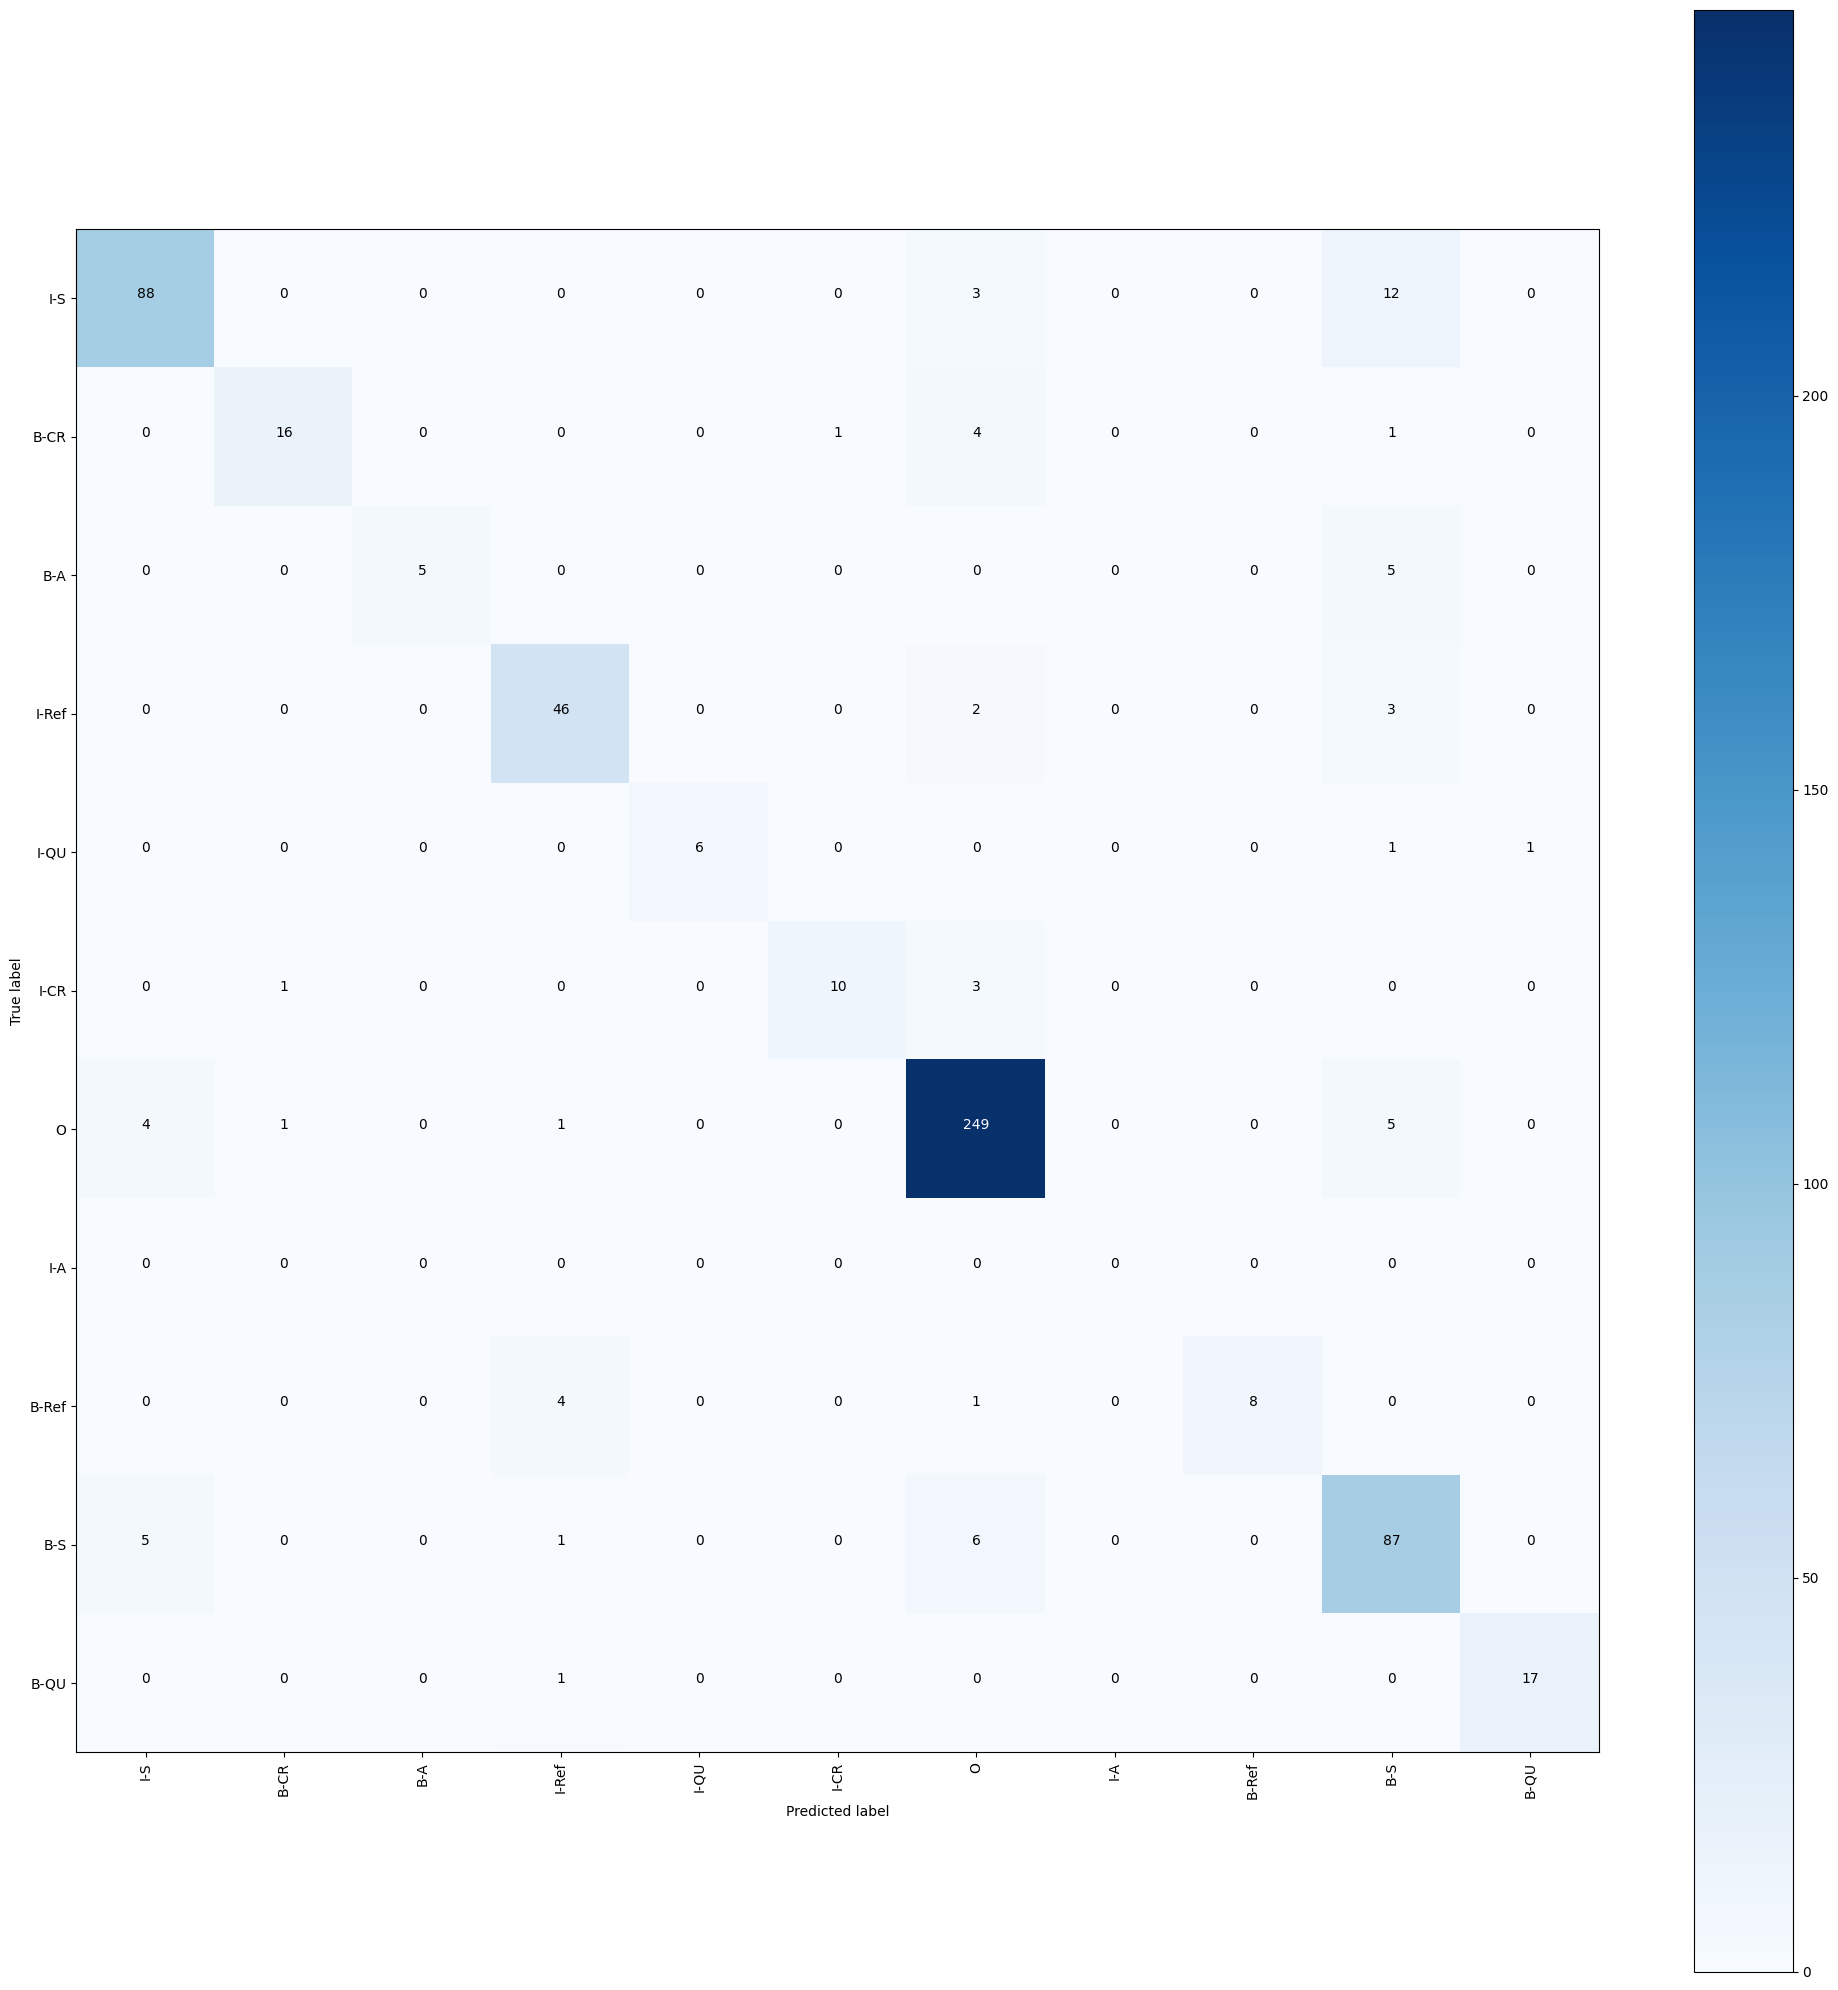

In [ ]:
#confusion matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    print(cm)
    plt.ion()
    plt.figure(num=None, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
label = ['I-S', 'B-CR', 'B-A', 'I-Ref', 'I-QU', 'I-CR' , 'O' ,'I-A', 'B-Ref', 'B-S' , 'B-QU']    

cnf_matrix = confusion_matrix(labels, predictions,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion matrix, without normalization')

In [ ]:
labels[2]

'B-A'